In [1]:
%matplotlib inline

In [2]:
import os
path = os.path.abspath(os.getcwd())

In [3]:
import math
import numpy as np
import pandas as pd
import pylab as py

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from fitter import Fitter

from scipy import fft
from scipy.optimize import curve_fit, minimize
from scipy.stats import kstest, norm, laplace, entropy, cauchy, entropy
from sklearn.feature_selection import mutual_info_regression

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('ggplot')

In [5]:
pd.set_option("display.max_colwidth",100)

In [6]:
# OPTIONS

all_data_files = [
     'moduntu_HP_desktop_trace_idle_22.12.14_6h',
     'moduntu_HP_desktop_trace_idle_22.12.15_20h',
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_idle_22.12.21_16h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_RPi_server32_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_desktop_trace_idle_22.11.15_1h',
     'moduntu_VM_desktop_trace_idle_22.12.13_12h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_idle_22.12.13_9h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h']

data_files = [  
     'moduntu_HP_desktop_trace_no-wifi_22.12.16_19h',
     'moduntu_HP_server_trace_no-wifi_22.12.20_16h',
     'moduntu_RPi_server32_trace_no-peri_23.01.19_17h',
     'moduntu_VM_desktop_trace_no-wifi_23.01.18_14h',
     'moduntu_VM_server_trace_no-wifi_23.01.18_14h']

# I - Data formatting
## 1) Text to CSV

def txtdmp_to_csv(filename):
    with open("data/" + filename + ".txt", "r") as textfile:
        textdump = textfile.read().splitlines()
        
    csvfile = open("csv/" + filename + ".csv", "w")
    csvfile.write(','.join(["count", "input1", "input2", "source_id", "idle"]))
    csvfile.write('\n')

    count = 0
    for line in textdump: 
        splitline = line.replace('@','').replace(',','').split(' ')
        values, start, idle = [], False, False

        for i in splitline: 
            # extract fast_mix values
            if i == "fast_mix:":
                start = True
                count += 1
                values.append(str(count))
            elif start:
                values.append(i)

            # Check for idle
            if i == "<idle>-0":
                idle = True

        if values != []:
            values.append(str(idle))
            csvfile.write(','.join(values))
            csvfile.write('\n')

    csvfile.close()

## 2) Data import

In [7]:
filename = data_files[2]
data_path = path + "\\csv\\" + filename + ".csv"
data = pd.read_csv(data_path)
data.head(5)

,count,input1,input2,source_id,idle
0,1,3710067642,4112549988,0,True
1,2,3710069328,4112549988,0,True
2,3,3718701703,3995109476,0,True
3,4,3748940765,3709896804,0,True
4,5,3766219786,4112549988,0,True


In [8]:
data[data["idle"]==True]

,count,input1,input2,source_id,idle
0,1,3710067642,4112549988,0,True
1,2,3710069328,4112549988,0,True
2,3,3718701703,3995109476,0,True
3,4,3748940765,3709896804,0,True
4,5,3766219786,4112549988,0,True
...,...,...,...,...,...
417098,417099,599194526,4112549988,0,True
417099,417100,599196285,4112549988,0,True
417100,417101,599197991,4112549988,0,True
417101,417102,599199694,4112549988,0,True


In [9]:
data.dtypes

count        int64
input1       int64
input2       int64
source_id    int64
idle          bool
dtype: object

In [10]:
def get_stats(data, col):
    print("Stats for " + col + " :")
    stats = data[col].value_counts()
    stats_perc = data[col].value_counts(normalize = True)
    
    total = 0
    for i in range(len(stats)):
        total = stats[i]
    
    for i in range(len(stats)):
        print(str(stats.index[i]) + "\t\t", str(stats[stats.index[i]]) + 
              '\t\t', str(round(stats_perc[stats.index[i]] * 100)) + '%')
        
    print()

In [11]:
for filename in data_files:
    print(filename)

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
moduntu_HP_server_trace_no-wifi_22.12.20_16h
moduntu_RPi_server32_trace_no-peri_23.01.19_17h
moduntu_VM_desktop_trace_no-wifi_23.01.18_14h
moduntu_VM_server_trace_no-wifi_23.01.18_14h


In [12]:
source_id_0, idle_true, count = 0,0,0
for filename in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    count += data.shape[0] 
    stats = data["source_id"].value_counts()
    source_id_0 += stats[0]
    stats = data["idle"].value_counts()
    idle_true += stats[True]
    
    print(filename)
    for col in ["source_id", "idle"]:
        get_stats(data, col)

print(count, source_id_0, source_id_0/count, idle_true, idle_true/count)

moduntu_HP_desktop_trace_no-wifi_22.12.16_19h
Stats for source_id :
0		 4241501		 100%
1		 238		 0%

Stats for idle :
True		 4218471		 99%
False		 23268		 1%

moduntu_HP_server_trace_no-wifi_22.12.20_16h
Stats for source_id :
0		 3017549		 100%
1		 280		 0%

Stats for idle :
True		 3014779		 100%
False		 3050		 0%

moduntu_RPi_server32_trace_no-peri_23.01.19_17h
Stats for source_id :
0		 417103		 100%

Stats for idle :
True		 409318		 98%
False		 7785		 2%

moduntu_VM_desktop_trace_no-wifi_23.01.18_14h
Stats for source_id :
0		 67140		 99%
1		 844		 1%

Stats for idle :
True		 40042		 59%
False		 27942		 41%

moduntu_VM_server_trace_no-wifi_23.01.18_14h
Stats for source_id :
0		 263785		 100%
1		 288		 0%

Stats for idle :
True		 246573		 93%
False		 17500		 7%

8008728 8007078 0.999793974773522 7929183 0.9900677111271603


## 3) Selecting source

Possible values for source_id:
 * 0 for interrupts
 * 1 for timing

In [13]:
data_select = data[data.source_id == 0] 
data_select = data_select[data_select.idle == True]

print("Fom", data.shape, "to", data_select.shape)

Fom (264073, 5) to (246287, 5)


In [14]:
def does_increment(df, columns):
    for col in columns:
        y = df[col].to_numpy()
        y =  y - np.roll(y.copy(), 1)
        y[0] = 0
        y = y < 0
        df.loc[:, col] = y
    
data.shape

(264073, 5)

In [15]:
data_test = data[data.source_id == 0]
data_test = data_test[data_test.idle == True] 
does_increment(data_test, ['input1'])

sum(data_test.input1)

0

# II - Direct analysis
## 1) Density visualization

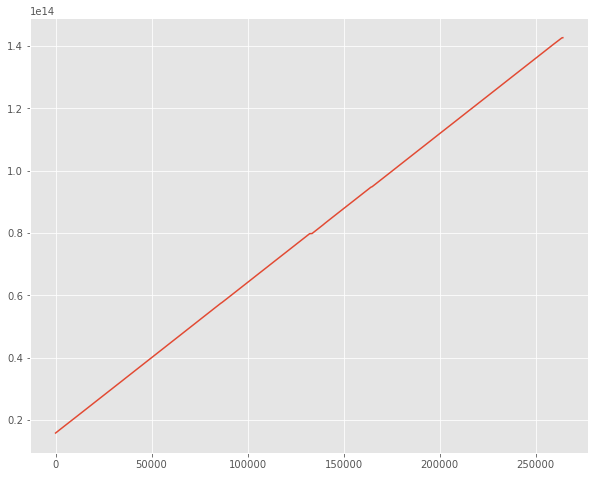

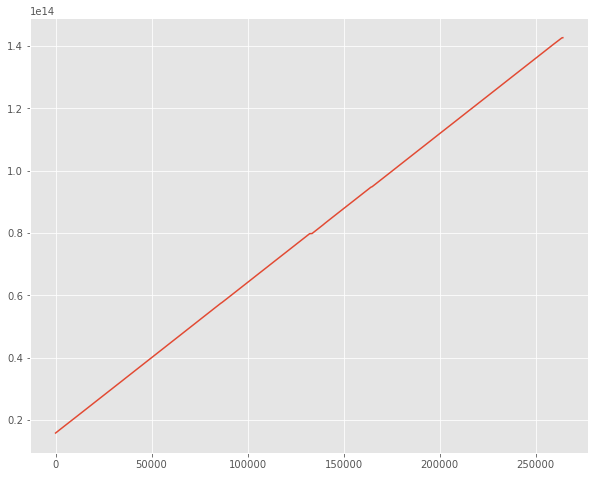

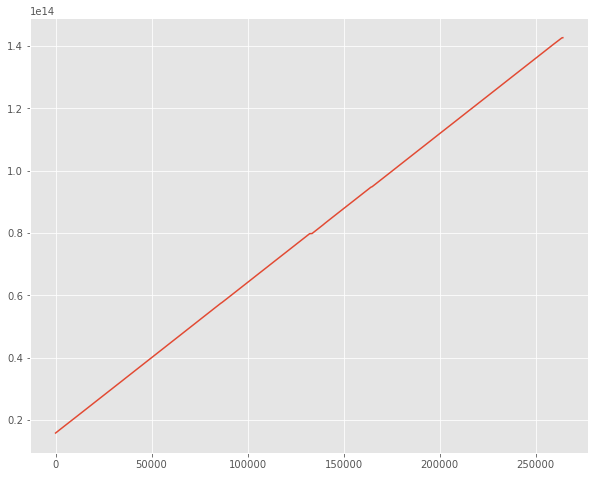

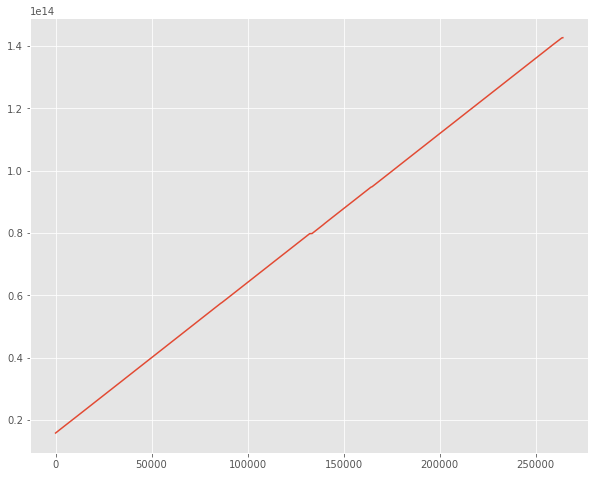

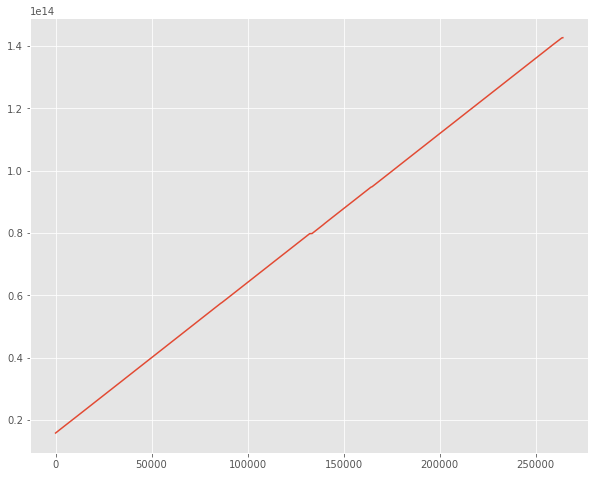

In [16]:
for file in data_files:
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    fig, ax = plt.subplots()
    ax.plot(data.input1)

In [17]:
def tup_string(selection):
    tup_str = ""
    for tup in selection:
        if not tup_str == "":
            tup_str += ", "
        tup_str += str(tup[0]) + " = " + str(tup[1])
    return tup_str

In [18]:
def data_hist(filename, column, selection = [], crop = (None, None), slicer = (None, None), log = False, bins = None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[0] of end of the data (if not idle)
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
    
    fig, ax = plt.subplots()
    bins = max(int(data.shape[0]/128) if not bins else bins, 1)
    plt.hist(data[column], density=True,  log = log, bins = bins)
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t # of elements:", str(data.shape[0]))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    
    ax.set_xlabel(u'Timestamp value')
    ax.set_ylabel('Frequency')

    plt.show()

Histogram of moduntu_HP_desktop_trace_no-wifi_22.12.16_19h :
	 selection: 
	 crop values: 0, 0
	 # of elements: 4241739
	 # of bins: 33138
	 log = False


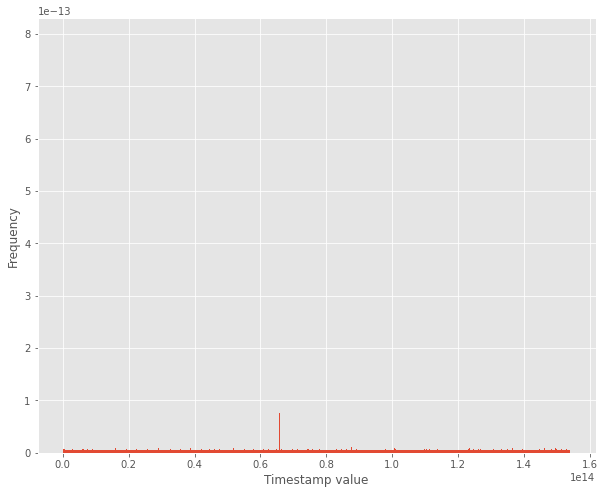

Histogram of moduntu_HP_server_trace_no-wifi_22.12.20_16h :
	 selection: 
	 crop values: 0, 0
	 # of elements: 3017829
	 # of bins: 23576
	 log = False


KeyboardInterrupt: 

In [19]:
for file in data_files:
    data_hist(file, 'input1', selection = [], crop = (0, 0), slicer = (None, None), 
              log = False)

In [ ]:
for file in data_files:
    data_hist(file, 'input1', selection = [('source_id', 0), ('idle', True)], crop = (0.2, 0.2), slicer = (None, None), 
              log = False, bins = 500)

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [20]:
def fft_autocorr(x):
    x = np.asarray(x)
    N = len(x)
#     x = x-x.mean()
    s = fft.fft(x, N*2-1)
    result = np.real(fft.ifft(s * np.conjugate(s), N*2-1))
    result = result[:N]
    result /= result[0]
    return np.array(result.astype(float))

def maple_autocorr(x): 
    x = np.asarray(x)
    y = x-x.mean()
#     y = x / max(x)
    
    autocorr = np.correlate(y, y, mode='full').astype(float)
#     autocorr = np.correlate(y, y, mode='same').astype(float)
    autocorr = autocorr[len(autocorr)//2:]
    autocorr /= autocorr[0]
    return np.array(autocorr.astype(float))

autocorr len: 1000


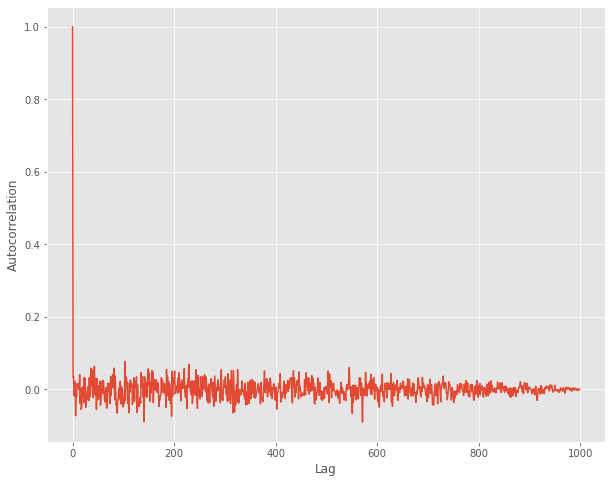

In [21]:
def plot_autocorr(x, i, method):
    if method=='maple':
        autocorr = maple_autocorr(x)
    else:
        autocorr = fft_autocorr(x)

    if i!=None:
        autocorr = autocorr[:i]
    print("autocorr len:", len(autocorr))
#     print("Autocorrelation:", autocorr)
    
    plt.plot(autocorr)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
x = np.random.randn(1000)
plot_autocorr(x, None, 'maple')

In [ ]:
def data_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]

    print("array len:", len(x))
    print("head values:", x[:10])
        
    plot_autocorr(x, max_lag, method)

In [ ]:
for file in data_files:
    data_autocorr(file, 'input1', (None, None), None, 'fft')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf 

data_path = path + "\\csv\\" + data_files[0] + ".csv"
data = pd.read_csv(data_path)
x = np.array(data['input1'])

# plot_acf(x)

In [ ]:
f = plt.figure()

ax1 = f.add_subplot(231)
ax1.set_title('Data')
ax1.plot(data.input1)

ax2 = f.add_subplot(232)
ax2.set_title('1st order')
ax2.plot(data.input1.diff())

ax3 = f.add_subplot(233)
ax3.set_title('2nd order')
ax3.plot(data.input1.diff().diff())

plt.show()

In [ ]:
f = plt.figure()
ax1a = f.add_subplot(231)
ax1a.set_title('Data autocorr')
ax1a.plot(fft_autocorr(data.input1))

ax2a = f.add_subplot(232)
ax2a.set_title('1st order autocorr')
ax2a.plot(fft_autocorr(data.input1.diff()))

ax3a = f.add_subplot(233)
ax3a.set_title('2nd order autocorr')
ax3a.plot(fft_autocorr(data.input1.diff().diff()))

plt.show()

# III - 1st order differencing
## 1) Probability functions

In [ ]:
def diff(df, columns):
    for col in columns:
        y = df[col].to_numpy()
        y =  y - np.roll(y.copy(), 1)
        y[0] = 0 # Should remove?
        df.loc[:, col] = y
#         return df.drop(0).reset_index(drop=True)

In [ ]:
def remove_extremes(x): 
#     x = x[0 <= x]
    n = len(x)
    Q1, Q3 = np.quantile(x, [0.25, 0.75])
    IQR = Q3 - Q1
    a, b = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    
    x = x[(a <= x) & (x <= b)]
    
#     print(n-len(x), a, b)
    return x

In [ ]:
def kstest_norm(x, bins):
    # Model fitting
    mu, sigma = np.mean(x), np.std(x)
    pdf_x = np.linspace(np.min(x),np.max(x), bins*10)
    pdf_y = 1.0 / np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(pdf_x - mu)**2/sigma**2)
    
    # Test
    ks_statistic, p_value = kstest(x, 'norm')
    print("\t Gauss model: mu="+str(mu)+", sigma="+str(sigma))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return  (pdf_x, pdf_y, mu, sigma) 

In [ ]:
def kstest_laplace(sample, bins):
    # Model fitting
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    fitter = Fitter(sample, distributions=['laplace'])
    fitter.fit()
    location, scale = fitter.fitted_param["laplace"]
    
    def cdf(x, loc, scale):
        return 1/2 * (1 + np.sign(x-loc) * (1 - np.exp(-(np.abs(x-loc)/scale))))
    
    # Test
    ks_statistic, p_value = kstest(sample, cdf, args=(location, scale))
    print("\t Exponential model: scale="+str(scale))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return (pdf_x, cdf(pdf_x, location, scale))

In [ ]:
def kstest_cauchy(sample, bins):
    # Model fitting
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    fitter = Fitter(sample, distributions=['cauchy'])
    fitter.fit()
    location, scale = fitter.fitted_param["cauchy"]
    
    def cdf(x, loc, scale):
        return  1/np.pi * np.arctan((x-loc)/scale) + 0.5
    
    def pdf(x, loc, scale):
        return  1/(np.pi * scale * (1 + ((x-loc)/scale)**2))
    
    # Test
    ks_statistic, p_value = kstest(sample, cdf, args=(location, scale))
    print("\t Model parameters: scale="+str(scale), "location="+str(location))
    print("\t KS test: statistic="+str(ks_statistic)+", pvalue="+str(p_value))
    
    return (pdf_x, pdf(pdf_x, location, scale))

In [ ]:
def pdf(x, loc, scale):
    return  1/(np.pi * scale * (1 + ((x-loc)/scale)**2))

def get_cauchy_pdf(pdf_x, loc, scale):
    return pdf(pdf_x, loc, scale)

def pdf_mixture(pdf_x, means, scales, weights):
    n = len(pdf_x)
    pdf = np.zeros(n)
    K = len(means)
    for k in range(K):
        pdf += weights[k] * get_cauchy_pdf(pdf_x, means[k], scales[k])
    return pdf / np.sum(weights)

def log_likelihood(params, data, K):
    # Unpack parameters
    means, scales, log_weights = params[:K], params[K:2*K], params[2*K:]
    weights = np.exp(log_weights) / np.sum(np.exp(log_weights))
    
    # Compute the log-likelihood
    ll = np.sum([weights[k] * np.log(cauchy.pdf(data, loc=means[k], scale=scales[k]))
                 for k in range(K)])
    return -ll

def fit_mixture_model(sample, K, bins):
    pdf_x = np.linspace(np.min(sample),np.max(sample), bins*10)
    
    # Initialize parameters
    np.random.seed(0)
    means = np.random.randn(K)
    scales = np.random.rand(K) + 1
    log_weights = np.zeros(K)
    params = np.concatenate([means, scales, log_weights])
    
    # Minimize the negative log-likelihood
    res = minimize(log_likelihood, params, args=(sample,K,), method='Nelder-Mead')
    
    # Extract the estimated parameters
    means, scales, log_weights = res.x[:K], res.x[K:2*K], res.x[2*K:]
    weights = np.exp(log_weights) / np.sum(np.exp(log_weights))
    
    print(means)
    print(scales)
    print(weights)
    
    pdf_y = pdf_mixture(pdf_x, means, scales, weights)
    return (pdf_x, pdf_y)

## 2) Density visualisation

In [ ]:
for file in data_files[:1]:
    print(file)
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    f = plt.figure()
    ax1 = f.add_subplot(221)
    ax1.set_title('Pandas diff')
    ax1.plot(data.input1.diff())
    
#     print("1st pd value", data.input1.diff()[0])
#     print("2nd pd value", data.input1.diff()[1])
    
    diff(data, ['input1'])
    ax2 = f.add_subplot(222)
    ax2.set_title('Homebrew diff')
    ax2.plot(data.input1)
    
#     print("1st HB value", data.input1[0])
#     print("2nd HB value", data.input1[1])
#     print()

    plt.show()

In [ ]:
def data_diff_hist(filename, column, selection = [], crop = (None, None), xzoom = (None, None), log = False, 
                   bins = None, model=None, k=None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 

    # Cropping: remove crop[0] % of beginning or crop[1] of end of the data
    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))
        
    diff(data, [column])
    x = remove_extremes(data[column])
#     x = data[column]
    bins = max(200 if bins==None else bins, 1)
    
    # Figure
    fig, ax = plt.subplots()
#     ax = x.plot(kind='hist', bins=bins, density=True, alpha=0.5, 
#                    color=list(plt.rcParams['axes.prop_cycle'])[1]['color'], log=log)
    plt.hist(x, density=True, log = log, bins = bins)
    
    if not xzoom==(None,None):
        plt.xlim(np.min(x) if xzoom[0]==None else xzoom[0], np.max(x) if xzoom[1]==None else xzoom[1])
    
    hist, bin_edges = np.histogram(x, bins=bins) 
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
    # Print info
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if not crop[0] else int(crop[0]*n))+",", str(0 if not crop[1] else int(crop[1]*n)))
    print("\t min-entropy:", min_entropy)
    print("\t entropy:", entropy)
    print("\t # of elements:", str(len(x)))
    print("\t # of bins:", str(bins))
    print("\t log =", str(log))
    print()
        
    if model=="norm": 
        pdf_x, pdf_y, mu, sigma = kstest_norm(x, bins)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='laplace':
        pdf_x, pdf_y = kstest_laplace(x, bins)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='cauchy':
        pdf_x, pdf_y = kstest_cauchy(x, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="mixed": 
        pdf_x, pdf_y = fit_mixture_model(x, 1 if k==None else k, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="test": 
        fitter = Fitter(x, distributions=['norm', 'laplace', 'cauchy'])
        fitter.fit()
        print(fitter.summary())
    elif model=='export':
        x.to_csv("csv/fit_results.csv")
        
    ax.set_xlabel(u'Timestamp delay')
    ax.set_ylabel('Frequency')
    
    plt.show()

In [ ]:
for file in data_files:
    data_diff_hist(file, 'input1', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model=None)

In [ ]:
for file in data_files:
    data_diff_hist(file, 'input1', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model="cauchy", k=1)

In [ ]:
for file in data_files:
    data_diff_hist(file, 'input1', selection = [], 
                   crop = (0.2, 0.2), log = False, bins = 500, model="cauchy")

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [ ]:
def data_diff_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]
    
    print("array len:", len(x))
    print("head values:", x[:10])
    
    plot_autocorr(x, max_lag, method)

In [ ]:
for file in data_files:
    data_diff_autocorr(file, 'input1', (None, None), None, 'fft')

# III - 2nd order differencing
## 1) Density visualization

In [ ]:
def data_double_diff_hist(filename, column, selection = [], crop = (None, None), xzoom = (None, None), log = False, 
                   bin_n = None, model=None):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    # Selection: select data according to other columns (origin, process...)
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 
        
    diff(data, [column])
    diff(data, [column])

    n = data.shape[0]
    if crop[0] != None and int(crop[0]*n) > 0: 
        data = data.tail(-int( n*crop[0] ))
    if crop[1] != None and int(crop[1]*n) > 0: 
        data = data.head(-int( n*crop[1] ))

    x = np.array(data[column])
#     x = np.array(remove_extremes(data[column]))
    bin_n = int(np.sqrt(len(x)))
#     print(bin_n)
    
    # Figure
    fig, ax = plt.subplots()
    hist_prob, bins, patches = plt.hist(x, density=True, log=log, bins=bin_n)
    prob = hist_prob / np.sum(hist_prob)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
#     hist, bin_edges = np.histogram(x, bins=bin_n) 
#     prob2 = hist / np.sum(hist)
#     min_entropy2 = -np.log2(np.max(prob))
#     entropy2 = -np.sum(prob * np.log2(prob + (prob==0)))
#     print("entropy 2:", entropy2, "min-entropy2:", min_entropy2)
#     ax.bar(bin_edges[:-1], prob, width=(bin_edges[1] - bin_edges[0]))
#     plt.hist(x, density=True, log = log, bins = bin_n)
    
    if not xzoom==(None,None):
        plt.xlim(np.min(x) if xzoom[0]==None else xzoom[0], np.max(x) if xzoom[1]==None else xzoom[1])
    
    # Print info
    print("Histogram of", filename, ":")
    print("\t selection:", tup_string(selection))
    print("\t crop values:", str(0 if crop[0]==None else str(crop[0]*n))+",", 
          str(0 if crop[1]==None else str(crop[1]*n)))
    print("\t min-entropy:", min_entropy)
    print("\t entropy:", entropy)
    print("\t # of elements:", str(len(x)))
    print("\t # of bins:", str(bin_n))
    print("\t log =", str(log))
    print()
    
    
    if model=="norm": 
        pdf_x, pdf_y, mu, sigma = kstest_norm(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='laplace':
        pdf_x, pdf_y = kstest_laplace(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'r--', label="pdf") 
    elif model=='cauchy':
        pdf_x, pdf_y = kstest_cauchy(x, bin_n)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="mixed": 
        pdf_x, pdf_y = fit_mixture_model(x, 1 if k==None else k, bins)
        ax.plot(pdf_x, pdf_y, 'b--', label="pdf")
    elif model=="test": 
        fitter = Fitter(x, distributions=['norm', 'laplace', 'cauchy'])
        fitter.fit()
        print(fitter.summary())
    elif model=='export':
        x.to_csv("csv/fit_results.csv")
        
    ax.set_xlabel(u'Timestamp double differential')
    ax.set_ylabel('Frequency')
    
    plt.show()

In [ ]:
for file in data_files:
    data_double_diff_hist(file, 'input1', crop = (0.2, 0.2), model=None)

In [ ]:
for file in data_files:
    data_double_diff_hist(file, 'input1', crop = (0.2, 0.2), model="cauchy")

## 2) Entropy estimation

In [ ]:
entropy64 = [4.298921996052419, 3.381687406273403, 1.642696748060507, 3.4797084812203267]
entropy32 = [1.9538217619509188]

sum(entropy64 + entropy32)/(len(entropy32)+len(entropy64))

In [ ]:
min_entropy64 = [1.9919937580276577, 1.896901204461242, 0.2447457744481864, 1.6115940642712376]
min_entropy32 = [0.7776742862014796]

sum(min_entropy64 + min_entropy32)/(len(min_entropy32)+len(min_entropy64))

In [ ]:
def histogram_entropy_estimation(filename, column, selection, crop, bins, order):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    for tup in selection: 
        data = data[data[tup[0]] == tup[1]] 
    
    for i in range(order):
        diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]
    
    hist, bin_edges = np.histogram(x, bins=bins) 
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log2(prob + (prob==0)))
    min_entropy = -np.log2(np.max(prob))
    
    print(filename)
    print('\t entropy', entropy)
    print('\t min_entropy', min_entropy)

In [ ]:
histogram_entropy_estimation(data_files[0], 'input1', [], (0.2,None), 1000, 0)
histogram_entropy_estimation(data_files[0], 'input1', [], (0.2,None), 1000, 1)
histogram_entropy_estimation(data_files[0], 'input1', [], (0.2,None), 1000, 2)

## 2) Independence of inputs
### A/ Autocorrelation coefficient

In [ ]:
def data_double_diff_autocorr(filename, column, crop, max_lag, method):
    # Import
    data_path = path + "\\csv\\" + filename + ".csv"
    data = pd.read_csv(data_path)
    
    diff(data, [column])
    diff(data, [column])
    x = np.array(data[column])
    
    n = len(x)
    i,j = 0 if crop[0]==None else int(crop[0]*n), n if crop[1]==None else int(crop[1]*n)
    if i<j: 
        x = x[i:j]

    print("array len:", len(x))
    print("head values:", x[:10])
        
    plot_autocorr(x, max_lag, method)

In [ ]:
for file in data_files:
    data_double_diff_autocorr(file, 'input1', (None, None), 100, 'fft')

### Proof of concept

In [ ]:
data_path = path + "\\csv\\" + data_files[0] + ".csv"
data = pd.read_csv(data_path)

diff(data, ['input1'])
diff(data, ['input1'])
x = np.array(data['input1'])
# x = np.array(remove_extremes(data['input1']))
bins = 1000
log = False

def compute_entropy(prob):
    return -np.sum(prob * np.log2(prob + (prob==0)))

def min_entropy(prob):
    return -np.log2(np.max(prob))


fig, ax = plt.subplots()
n, bins, patches = plt.hist(x, density=True, log=log, bins=bins)

# # Calculate the probability
prob1 = n / np.sum(n)
entropy1 = compute_entropy(prob1)
min_entropy1 = min_entropy(prob1)

# Compute the density distribution and entropy level using numpy
hist, bin_edges = np.histogram(x, bins=bins)

# Calculate the probability
prob2 = hist / np.sum(hist)
entropy2 = compute_entropy(prob2)
min_entropy2 = min_entropy(prob2)

# fig, ax = plt.subplots()
# ax.bar(bin_edges[:-1], prob2, width=(bin_edges[1] - bin_edges[0]))

print("Matplotlib entropy:", entropy1, "Min-entropy:", min_entropy1)
print("NumPy entropy:", entropy2, "Min-entropy:", min_entropy2)

In [ ]:
import math

def cauchy_cdf(g, x0, x):
    r = (1.0 / math.pi) * math.atan((x - x0) / g) + 0.5
    if 0.0 < r <= 1.0:
        return r
    else:
        return 0.0
    
def cauchy_pdf(g, x0, x):
    r = 1 / (math.pi * g * (1 + ((x - x0) / g) ** 2))
    if 0.0 < r <= 1.0:
        return r
    else:
        return 0.0
    
def compute_entropy(probs):
    num_bins = int(math.sqrt(len(probs)))
    binned_probs = bin_probabilities(probs, num_bins)
    return -np.sum(binned_probs * np.log2(binned_probs + np.finfo(float).eps))

def min_entropy(probs):
    num_bins = int(math.sqrt(len(probs)))
    binned_probs = bin_probabilities(probs, num_bins)
    return -np.log2(np.max(binned_probs))

def bin_probabilities(probabilities, num_bins):
    step = len(probabilities) // num_bins
    binned_probabilities = [sum(probabilities[i * step:(i + 1) * step]) for i in range(num_bins)]
    return np.array(binned_probabilities)
    
params = (200,0)
discrete_range = np.arange(0, 2**16)

prob_pdf = np.array([cauchy_pdf(params[0], params[1], x) 
                    for x in discrete_range])
prob_cdf = np.array([cauchy_cdf(params[0], params[1], x+0.5) - cauchy_cdf(params[0], params[1], x-0.5) 
                    for x in discrete_range])

prob_pdf = prob_pdf/np.sum(prob_pdf)
prob_cdf = prob_cdf/np.sum(prob_cdf)

entropy1 = compute_entropy(prob_pdf)
min_entropy1 = min_entropy(prob_pdf)
print("PDF entropy:", entropy1, "Min-entropy:", min_entropy1)

entropy2 = compute_entropy(prob_cdf)
min_entropy2 = min_entropy(prob_cdf)
print("CDF entropy:", entropy1, "Min-entropy:", min_entropy1)

fig, ax = plt.subplots()
ax.plot(prob_cdf)
ax.plot(prob_pdf)
plt.show()